In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

# Helper functions

In [99]:
def plot_hist(returns):
    
    zeta = 0.05
    alpha = 0.05
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.axvline(var, c='y', linestyle='--', label=f'VaR={var:4.2}')
    plt.axvline(cvar, c='r', linestyle='--', label=f'CVaR={cvar:4.2}')
    plt.axvline(zeta, c='g', linestyle='--', label=f'P={p}')
    plt.legend()

# Generate returns

In [2]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [3]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 293.41it/s]


In [4]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.111588,0.185445,0.161610,0.108894,0.077804,0.076065,0.016832
1,0.075382,0.018312,-0.003182,-0.037618,-0.019501,-0.036197,-0.074053
2,0.203444,0.168818,0.160884,-0.198696,0.087980,0.809159,0.107549
3,0.174342,0.272652,0.139283,0.195973,0.187876,0.153496,0.106824
4,0.075768,0.094670,0.011364,0.095200,0.101521,0.010517,-0.029213
...,...,...,...,...,...,...,...
995,0.216016,0.101757,0.481145,0.131455,-0.719913,0.062105,0.044084
996,0.276465,0.236015,0.285515,0.332774,0.368256,0.113498,0.168820
997,0.275035,0.226176,0.179945,0.325228,-0.182384,0.465101,0.134615
998,0.084103,0.013292,0.087913,-0.004762,0.097507,0.184005,-0.029466


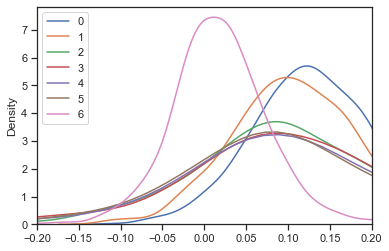

In [5]:
for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

# Optimization with riskfolio

In [6]:
import riskfolio as rp
import pandas as pd

In [104]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(weights.T)

,0,1,2,3,4,5,6
weights,0.538431,0.263887,0.131116,2.494234e-11,0.066566,3.129740e-14,8.917373e-14


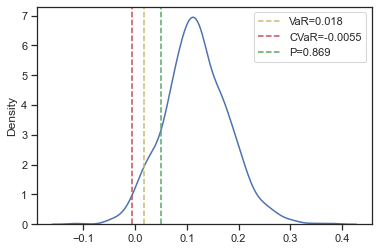

In [105]:
portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

Objective: 117.32064694407967
Portfolio weights:


,0,1,2,3,4,5,6
0,0.497126,0.239083,0.117557,0.0374,0.072356,0.023185,0.013294


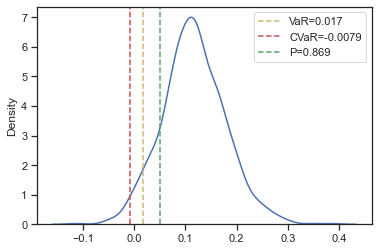

In [112]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np

returns = log_ret
alpha = 0.05

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets, 1))
k = cp.Variable((1, 1))
var = cp.Variable((1, 1))
Z1 = cp.Variable((n_returns, 1))

X = returns @ weights
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z1)

constraints = [Z1 * 1000 >= 0, Z1 * 1000 >= -X * 1000 - var * 1000]
objective = cp.Minimize(cvar * 1000)

log_w = cp.Variable((n_assets, 1))
constraints += [
    # rb.T @ cp.log(w) >= 1,
    np.ones((1, n_assets)) @ log_w >= 1,
    cp.ExpCone(log_w * 1000, np.ones((n_assets, 1)) * 1000, weights * 1000),
    weights * 1000 >= 0,
    cp.sum(weights) * 1000 == k * 1000,
]

# naive idea for the return constraint:
# constraints += [cp.sum(returns @ weights >= 0.05) >= 0.7 * n_returns]

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = (weights.value / k.value).T[0]
portfolio_returns = returns @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns)